In [1]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise


# 10. Selection of preferred energy compaction options

The remainder of this project will concentrate on developing the rest of
an image compression system, based on a few of the filtering /
transformation schemes studied so far.

Since the subsequent processes are non-linear, we cannot expect to be able to
choose precisely the right front-end at this stage, so we adopt the pragmatic
approach of picking about three good candidates and trust that one of these
will lead to a near-optimum solution in the end. Remember that up to this point we have only been using entropy to give us an _estimate_ of the number of bits required, the accuracy of which is affected by subsequent stages.

At this stage it is worth trying your schemes with all three
test images, (`Lighthouse`, `Bridge`, and `Flamingo`). You will find `Bridge` more difficult to compress than the other two. You may also want to introduce other images of your own.

In [2]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

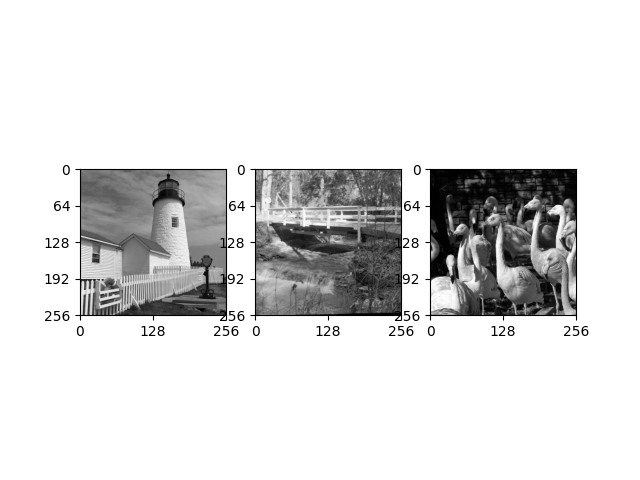

In [3]:
fig, axs = plt.subplots(1, 3)
plot_image(lighthouse, ax=axs[0])
plot_image(bridge, ax=axs[1])
plot_image(flamingo, ax=axs[2])

Write `.py` files to implement each of your
chosen schemes, so that you do not have to remember long sequences
of commands each time you run them. You can easily edit the M-files to introduce different options
later.  Using plenty of comments in these files will help when you want to change them.

# 11. Centre-clipped linear quantisers

The quantisers that you have used so far have all been uniform quantisers
(i.e.  all steps have been the same size).  However the probability
distributions of the intensities of the bandpass sub-images from the energy
compaction front-ends are usually highly peaked at zero.  The amount of data
compression depends heavily on the proportion of data samples which are
quantised to zero; if this approaches unity then high compression is
achieved.

Hence it is often found desirable to make the quantiser non-linear
so that more samples tend to be quantised to zero.  A simple way
to achieve this is to widen the step-size of the "zero" step.  In
a uniform quantiser, the "zero" step is normally centred on zero,
with rises to the next level at $\pm$ half of the step-size on
each side of zero. `quantise` allows a third argument `rise1` to be specified, which is
the point at which the first rise occurs on each side of the zero step.  A
value of `rise1` = `step/2` is the default, but `rise1` = $\left\{0.5, 1, 1.5\right\}\times$ `step` are worth investigating. To show what effect these have, try:

```python
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
```

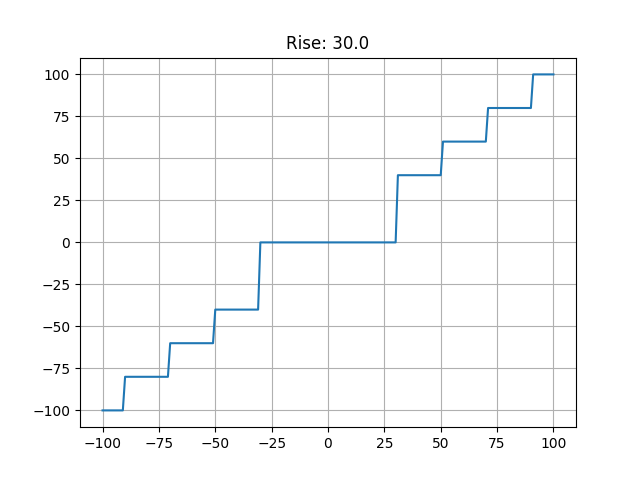

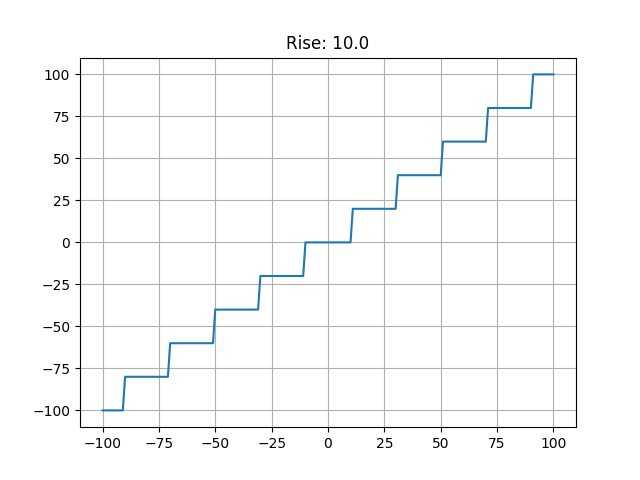

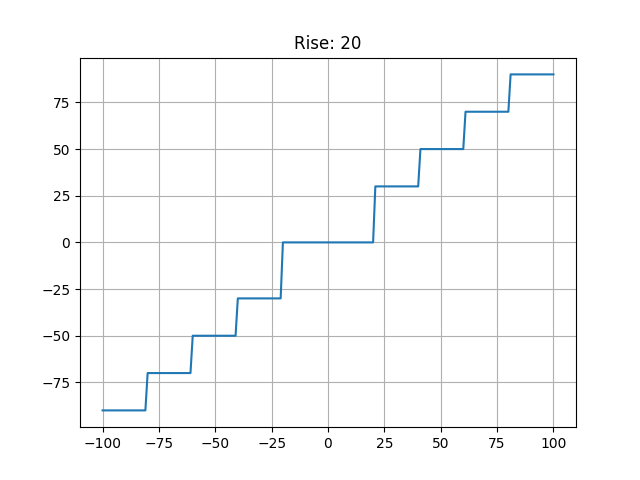

In [4]:
# your code here
x = np.arange(-100,100+1)
rise1 = [0.5*20,1*20,1.5*20]
for r in rise1:
    # rise1 = step/2
    y = quantise(x,20,r)
    fig,ax = plt.subplots()
    ax.plot(x,y)
    ax.grid()
    title = f'Rise: {r}'
    ax.set_title(title)
plt.show()

A wider zero step means that more samples will be coded as zero and so the
entropy of the data will be reduced.  The use of a wide zero step is
beneficial if it results in a better entropy vs. error tradeoff than a uniform
quantiser.

<div class="alert alert-block alert-danger">

For each of your preferred front-end
schemes, investigate the effects of varying the first rise of the
quantiser.  To do this, you could plot how the quantising error
varies as a function of the number of bits for a few different ratios of
`rise1` to step-size, and hence find the ratio which gives the
best compression for a given rms error. </div>

In [5]:
X,_ = load_mat_img(img='lighthouse.mat', img_info='X')
X = X - 128.0

In [6]:
def dctbpp(Yr,N):
    sub_images = Yr.reshape(N,256//N,N,256//N).swapaxes(1,2)
    total_bits = 0
    for i in range(sub_images.shape[0]):
        for j in range(sub_images.shape[1]):
            Ys = sub_images[i][j]
            total_bits += bpp(Ys)*Ys.size
    return total_bits

In [31]:
#DCT
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
from cued_sf2_lab.dct import dct_ii, colxfm, regroup
step_sizes = np.linspace(1, 30, 300)
ratios = [0.5, 0.75,0.8,0.9, 1.0, 1.5,1.75,2]
number_of_bits_DCT = []
rms_error_DCT = []
for ratio in ratios:
    temp_number_of_bits = []
    temp_rms_error = []
    for step in step_sizes:
        DCT_N = 8
        C8 = dct_ii(DCT_N)
        Y8 = colxfm(colxfm(X, C8).T, C8).T
        Y8q = quantise(Y8, step, step*ratio)
        temp_number_of_bits.append(dctbpp(regroup(Y8q, DCT_N), DCT_N))
        Zq = colxfm(colxfm(Y8q.T, C8.T).T, C8.T)
        temp_rms_error.append(np.std(X - Zq))
        
    number_of_bits_DCT.append(temp_number_of_bits)
    rms_error_DCT.append(temp_rms_error)

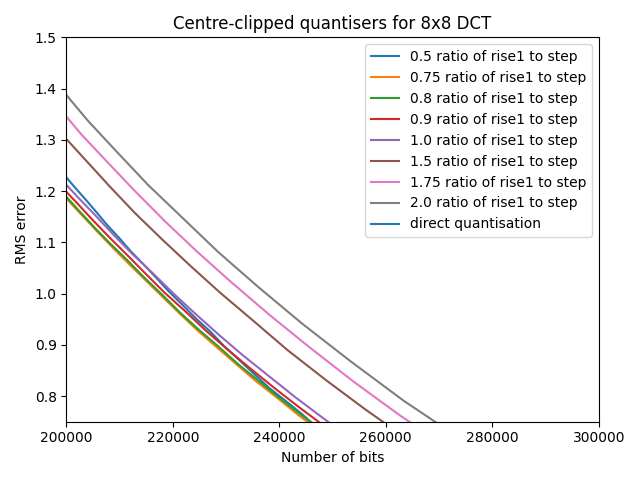

In [39]:
fig, ax = plt.subplots()
ax.plot(number_of_bits_DCT[0], rms_error_DCT[0], label = '0.5 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[1], rms_error_DCT[1], label = '0.75 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[2], rms_error_DCT[2], label = '0.8 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[3], rms_error_DCT[3], label = '0.9 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[4], rms_error_DCT[4], label = '1.0 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[5], rms_error_DCT[5], label = '1.5 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[6], rms_error_DCT[6], label = '1.75 ratio of rise1 to step')
ax.plot(number_of_bits_DCT[7], rms_error_DCT[7], label = '2.0 ratio of rise1 to step')

ax.set(title  = "Centre-clipped quantisers for 8x8 DCT")
rms_direct = np.std(X - quantise(X,17))
ax.axhline(y=rms_direct, label="direct quantisation")
ax.set_xlabel("Number of bits")
ax.set_ylabel("RMS error")
ax.set_xlim((200000, 300000))
ax.set_ylim((0.75,1.5))
fig.tight_layout()
plt.legend()

In [56]:
#LBT
from cued_sf2_lab.lbt import pot_ii
step_sizes = np.linspace(1, 30, 300)
ratios = [0.5, 0.75, 1.0, 1.5,1.75,2]
number_of_bits_LBT = []
rms_error_LBT = []
for ratio in ratios:
    temp_number_of_bits = []
    temp_rms_error = []
    for step in step_sizes:
        LBT_N = 8
        C8 = dct_ii(LBT_N)
        Pf, Pr = pot_ii(LBT_N, np.sqrt(2))
        t = np.s_[LBT_N//2:-LBT_N//2]
        Xp = X.copy()
        Xp[t,:] = colxfm(Xp[t,:], Pf)
        Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
        
        Y8 = colxfm(colxfm(Xp, C8).T, C8).T
        Y8q = quantise(Y8, step, step*ratio)
        temp_number_of_bits.append(dctbpp(regroup(Y8q, LBT_N), LBT_N))
        
        Zq = colxfm(colxfm(Y8q.T, C8.T).T, C8.T)
        Zp = Zq.copy()  #copy the non-transformed edges directly from Z
        Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
        Zp[t,:] = colxfm(Zp[t,:], Pr.T)

        
        temp_rms_error.append(np.std(X - Zp))
        
    number_of_bits_LBT.append(temp_number_of_bits)
    rms_error_LBT.append(temp_rms_error)

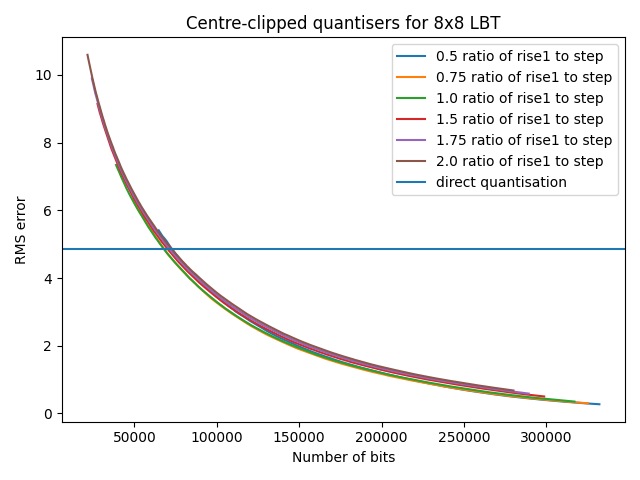

In [58]:
fig, ax = plt.subplots()
ax.plot(number_of_bits_LBT[0], rms_error_LBT[0], label = '0.5 ratio of rise1 to step')
ax.plot(number_of_bits_LBT[1], rms_error_LBT[1], label = '0.75 ratio of rise1 to step')
ax.plot(number_of_bits_LBT[2], rms_error_LBT[2], label = '1.0 ratio of rise1 to step')
ax.plot(number_of_bits_LBT[3], rms_error_LBT[3], label = '1.5 ratio of rise1 to step')
ax.plot(number_of_bits_LBT[4], rms_error_LBT[4], label = '1.75 ratio of rise1 to step')
ax.plot(number_of_bits_LBT[5], rms_error_LBT[5], label = '2.0 ratio of rise1 to step')
rms_direct = np.std(X - quantise(X,17))
ax.axhline(y=rms_direct, label="direct quantisation")
ax.set(title  = "Centre-clipped quantisers for 8x8 LBT")
ax.set_xlabel("Number of bits")
ax.set_ylabel("RMS error")
# ax.set_xlim((60000, 110000))
# ax.set_ylim((2,5.5))
fig.tight_layout()
plt.legend()

In [21]:
from cued_sf2_lab.dwt import dwt
from cued_sf2_lab.dwt import idwt
def nlevdwt(X, n):
    Y = X.copy()
    m = 256
    Y = dwt(X)
    for _ in range(n-1):
        m = m // 2
        Y[:m, :m] = dwt(Y[:m, :m])
 
    return Y,m


def nlevidwt(Y, n,m):
    X = Y.copy()
    # m = len(X)//(2**(n-1))
    for _ in range(n):
        X[:m, :m] = idwt(X[:m,:m])
        m = m * 2
    return X
n = 4
Y, m = nlevdwt(X, n)
print(type(Y))

<class 'numpy.ndarray'>


In [25]:
def nlevdwt(X, n):
    m = X.shape[0]
    Y = X.copy()
    for _ in range(n):
        Y[:m, :m] = dwt(Y[:m, :m])
        m = m//2
    return Y

def nlevidwt(Y, n):
    m = Y.shape[0]//2**(n-1)
    Z = Y.copy()
    for _ in range(n):
        Z[:m , :m] = idwt(Z[:m, :m])
        m = m*2
    return Z

In [27]:
def quantdwt(Y, dwtstep, ratio):
    n = dwtstep.shape[1] - 1
    dwtent = np.zeros(dwtstep.shape)
    m = Y.shape[0]
    Yq = Y.copy()
    for l in range(n):
        Yq[0:m//2, m//2: m] = quantise(Yq[0:m//2, m//2:m], dwtstep[0, l], ratio*dwtstep[0, l])
        dwtent[0,l] = bpp(Yq[0:m//2, m//2: m])*Yq[0:m//2, m//2: m].size
        
        Yq[m//2: m, 0:m//2] = quantise(Yq[m//2: m, 0:m//2], dwtstep[1, l], ratio*dwtstep[1, l])
        dwtent[1,l] = bpp(Yq[m//2: m, 0:m//2])*Yq[m//2: m, 0:m//2].size
        
        Yq[m//2: m, m//2: m] = quantise(Yq[m//2: m, m//2: m], dwtstep[2, l], ratio*dwtstep[2, l])
        dwtent[2,l] = bpp(Yq[m//2: m, m//2: m])*Yq[m//2: m, m//2: m].size
        m = m//2
                          
    Yq[0:m, 0:m] = quantise(Yq[0:m, 0:m], dwtstep[0,n], ratio*dwtstep[0,n])
    dwtent[0,n] = bpp(Yq[0:m, 0:m])*Yq[0:m, 0:m].size
    
    return Yq, dwtent

def step_ratios(n):
    X_test = np.zeros((256, 256))
    dwt_ratios = np.ones((3, n + 1))
    m = 256
    for i in range(1, n + 1):
        Ytr = nlevdwt(X_test, i)
        Ytr[0:m//2, m//2: m][m//4][m//4] = 100
        Ztr = nlevidwt(Ytr, i)
        dwt_ratios[0][i-1] = np.sum(Ztr**2.0)
        
        Ybl = nlevdwt(X_test, i)
        Ybl[m//2: m, 0:m//2][m//4][m//4] = 100
        Zbl = nlevidwt(Ybl, i)
        dwt_ratios[1][i-1] = np.sum(Zbl**2.0)
        
        Ybr = nlevdwt(X_test, i)
        Ybr[m//2: m, m//2: m][m//4][m//4] = 100
        Zbr = nlevidwt(Ybr, i)
        dwt_ratios[2][i-1] = np.sum(Zbr**2.0)
        m = m//2
    Ytr = nlevdwt(X_test, n)
    Ytr[0:m, 0:m][m//2][m//2] = 100
    Ztr = nlevidwt(Ytr, n)
    dwt_ratios[0][n] = np.sum(Ztr**2.0)
    
    dwt_ratios = 1/np.sqrt(dwt_ratios)
    dwt_ratios = dwt_ratios/np.amax(dwt_ratios[0][0])
    dwt_ratios[-1][-1] = 0
    dwt_ratios[-2][-1] = 0
    return dwt_ratios

def compression_ratio_equal_MSE(X, n, ratio, optimal_step_scalar, dwt_ratios, ref_step):
    Y = nlevdwt(X, n)
    dwt_ratios = optimal_step_scalar*dwt_ratios
    Yq, dwtent = quantdwt(Y, dwt_ratios, ratio)
    return bpp(quantise(X, ref_step))*X.size/np.sum(dwtent)

def optimisation_equal_MSE(X, n, ratio, target_RMS, dwt_ratios, start, end, size):
    Y = nlevdwt(X, n)
    step_sizes = np.linspace(start, end, size)
    lowest = float("inf")
    
    for step in step_sizes:
        mse_dwtstep = dwt_ratios*step
        Yq, dwtent = quantdwt(Y, mse_dwtstep, ratio)
        Zq = nlevidwt(Yq, n)
        diff = abs(np.std(X - Zq) - target_RMS)
        if diff < lowest:
            lowest = diff
            output = step
        
    return output

# DWT_compression_ratios = []
# for ratio in ratios_list:
#     step_DWT = optimisation_equal_MSE(X, 5, ratio, target_RMS, step_ratios(5), 1, 30, 300)
#     DWT_compression_ratios.append(compression_ratio_equal_MSE(X, 5, ratio, step_DWT, step_ratios(5), 17))

# print(DWT_compression_ratios)

In [28]:
#DWT
step_sizes = np.linspace(1, 30, 300)
ratios = [0.5, 0.8, 1.0, 1.5]
number_of_bits_DWT = []
rms_error_DWT = []
for ratio in ratios:
    temp_number_of_bits = []
    temp_rms_error = []
    for step in step_sizes:
        DWT_n = 5
        Y5 = nlevdwt(X, DWT_n)
        dwtstep5 = step*step_ratios(DWT_n)
        Y5q, dwtent5 = quantdwt(Y5, dwtstep5, ratio)
        temp_number_of_bits.append(np.sum(dwtent5))
        Zq = nlevidwt(Y5q, DWT_n)
        temp_rms_error.append(np.std(X - Zq))
        
    number_of_bits_DWT.append(temp_number_of_bits)
    rms_error_DWT.append(temp_rms_error)

In [ ]:
fig, ax = plt.subplots()
ax.plot(ratios_list, DCT_compression_ratios, "-o", label = "DCT")
ax.plot(ratios_list, LBT_compression_ratios, "-o", label = "LBT")
ax.plot(ratios_list, DWT_compression_ratios, "-o", label = "DWT")
ax.set_xlabel("Ratio of rise1 to step")
ax.set_ylabel("Compression ratio")
ax.set(title  = "Compression ratio for different schemes")
fig.tight_layout()
ax.legend()

In [ ]:
from cued_sf2_lab.dwt import dwt
from cued_sf2_lab.dwt import idwt

def nlevdwt(X, n):
    m = X.shape[0]
    Y = X.copy()
    for _ in range(n):
        Y[:m, :m] = dwt(Y[:m, :m])
        m = m//2
    return Y

def nlevidwt(Y, n):
    m = Y.shape[0]//2**(n-1)
    Z = Y.copy()
    for _ in range(n):
        Z[:m , :m] = idwt(Z[:m, :m])
        m = m*2
    return Z

def quantdwt(Y, dwtstep, ratio):
    n = dwtstep.shape[1] - 1
    dwtent = np.zeros(dwtstep.shape)
    m = Y.shape[0]
    Yq = Y.copy()
    for l in range(n):
        Yq[0:m//2, m//2: m] = quantise(Yq[0:m//2, m//2:m], dwtstep[0, l], ratio*dwtstep[0, l])
        dwtent[0,l] = bpp(Yq[0:m//2, m//2: m])*Yq[0:m//2, m//2: m].size
        
        Yq[m//2: m, 0:m//2] = quantise(Yq[m//2: m, 0:m//2], dwtstep[1, l], ratio*dwtstep[1, l])
        dwtent[1,l] = bpp(Yq[m//2: m, 0:m//2])*Yq[m//2: m, 0:m//2].size
        
        Yq[m//2: m, m//2: m] = quantise(Yq[m//2: m, m//2: m], dwtstep[2, l], ratio*dwtstep[2, l])
        dwtent[2,l] = bpp(Yq[m//2: m, m//2: m])*Yq[m//2: m, m//2: m].size
        m = m//2
                          
    Yq[0:m, 0:m] = quantise(Yq[0:m, 0:m], dwtstep[0,n], ratio*dwtstep[0,n])
    dwtent[0,n] = bpp(Yq[0:m, 0:m])*Yq[0:m, 0:m].size
    
    return Yq, dwtent

def step_ratios(n):
    X_test = np.zeros((256, 256))
    dwt_ratios = np.ones((3, n + 1))
    m = 256
    for i in range(1, n + 1):
        Ytr = nlevdwt(X_test, i)
        Ytr[0:m//2, m//2: m][m//4][m//4] = 100
        Ztr = nlevidwt(Ytr, i)
        dwt_ratios[0][i-1] = np.sum(Ztr**2.0)
        
        Ybl = nlevdwt(X_test, i)
        Ybl[m//2: m, 0:m//2][m//4][m//4] = 100
        Zbl = nlevidwt(Ybl, i)
        dwt_ratios[1][i-1] = np.sum(Zbl**2.0)
        
        Ybr = nlevdwt(X_test, i)
        Ybr[m//2: m, m//2: m][m//4][m//4] = 100
        Zbr = nlevidwt(Ybr, i)
        dwt_ratios[2][i-1] = np.sum(Zbr**2.0)
        m = m//2
    Ytr = nlevdwt(X_test, n)
    Ytr[0:m, 0:m][m//2][m//2] = 100
    Ztr = nlevidwt(Ytr, n)
    dwt_ratios[0][n] = np.sum(Ztr**2.0)
    
    dwt_ratios = 1/np.sqrt(dwt_ratios)
    dwt_ratios = dwt_ratios/np.amax(dwt_ratios[0][0])
    dwt_ratios[-1][-1] = 0
    dwt_ratios[-2][-1] = 0
    return dwt_ratios

def compression_ratio_equal_MSE(X, n, ratio, optimal_step_scalar, dwt_ratios, ref_step):
    Y = nlevdwt(X, n)
    dwt_ratios = optimal_step_scalar*dwt_ratios
    Yq, dwtent = quantdwt(Y, dwt_ratios, ratio)
    return bpp(quantise(X, ref_step))*X.size/np.sum(dwtent)

def optimisation_equal_MSE(X, n, ratio, target_RMS, dwt_ratios, start, end, size):
    Y = nlevdwt(X, n)
    step_sizes = np.linspace(start, end, size)
    lowest = float("inf")
    
    for step in step_sizes:
        mse_dwtstep = dwt_ratios*step
        Yq, dwtent = quantdwt(Y, mse_dwtstep, ratio)
        Zq = nlevidwt(Yq, n)
        diff = abs(np.std(X - Zq) - target_RMS)
        if diff < lowest:
            lowest = diff
            output = step
        
    return output

ratios_list = [0.5, 0.8, 1.0, 1.5]
DWT_compression_ratios = []
for ratio in ratios_list:
    step_DWT = optimisation_equal_MSE(X, 5, ratio, target_RMS, step_ratios(5), 1, 30, 300)
    DWT_compression_ratios.append(compression_ratio_equal_MSE(X, 5, ratio, step_DWT, step_ratios(5), 17))

print(DWT_compression_ratios)

NameError: name 'ratios_list' is not defined

In [15]:
#DWT
step_sizes = np.linspace(1, 30, 300)
ratios = [0.5, 0.8, 1.0, 1.5]
number_of_bits_DWT = []
rms_error_DWT = []
for ratio in ratios:
    temp_number_of_bits = []
    temp_rms_error = []
    for step in step_sizes:
        DWT_n = 5
        Y5 = nlevdwt(X, DWT_n)
        dwtstep5 = step*step_ratios(DWT_n)
        Y5q, dwtent5 = quantdwt(Y5, dwtstep5, ratio)
        temp_number_of_bits.append(np.sum(dwtent5))
        Zq = nlevidwt(Y5q, DWT_n)
        temp_rms_error.append(np.std(X - Zq))
        
    number_of_bits_DWT.append(temp_number_of_bits)
    rms_error_DWT.append(temp_rms_error)

KeyboardInterrupt: 

In [5]:
from cued_sf2_lab.dct import dct_ii, colxfm, regroup
def lbt(X, s, N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T
    Y = colxfm(colxfm(Xp, C).T, C).T
    return Y


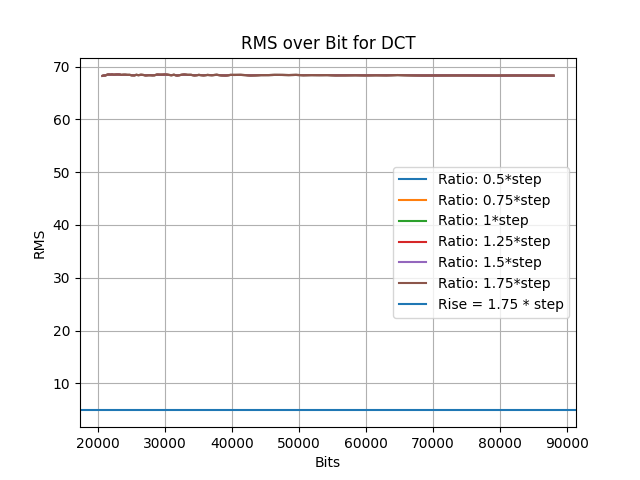

In [6]:
# You may wish to work in standalone python files (instead of notebooks) at this point!
# DCT
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
from cued_sf2_lab.dct import colxfm


fig, ax = plt.subplots()

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

X_pre_zero_mean, _ = load_mat_img(img='lighthouse.mat', img_info='X')
X = X_pre_zero_mean - 128.0
N = 8

# C8 = dct_ii(8)
# Y = colxfm(colxfm(X, C8).T, C8).T

def dctbpp(Yr,N):
    sub_images = Yr.reshape(N,256//N,N,256//N).swapaxes(1,2)
    total_bits = 0
    for i in range(sub_images.shape[0]):
        for j in range(sub_images.shape[1]):
            Ys = sub_images[i][j]
            total_bits += bpp(Ys)*Ys.size
    return total_bits

ratio = [0.5,0.75,1,1.25,1.5,1.75]
for r in ratio:
    rms = []
    bit = []
    
    for step_size in np.arange(20, 100):
        N = 8
        s = np.sqrt(2)
        # Perform quantization and other calculations
        Y = lbt(X, s, N)
        Yq = quantise(Y, step_size)
        Yr = regroup(Yq, N)/N
        Pf, Pr = pot_ii(N, s)
        C = dct_ii(N)
        t = np.s_[N//2:-N//2]
        Zp = Yq.copy()
        Zp[:, t] = colxfm(Zp[:, t].T, Pr.T).T
        Zp[t, :] = colxfm(Zp[t, :], Pr.T)
    
        # Yq = quantise(Y, step_size, r*step_size)
        # Yr = regroup(Yq, N)/N
        # Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
        # Calculate rms_error_Z and append to rms list
        rms_error_Z = np.std(X - Zp)
        rms.append(rms_error_Z)
        
        # Calculate total_bits_bpp and append to bit list
        total_bits_bpp = dctbpp(Yr,N)
        bit.append(total_bits_bpp)

    # Plot the bit over RMS for the current ratio
    plt.plot(bit, rms, label=f"Ratio: {r}*step")
rms_direct = np.std(X - quantise(X,17))
ax.axhline(y=rms_direct, label=f"Rise = {r} * step")
ax.set_ylabel('RMS')
ax.set_xlabel('Bits')
ax.set_title('RMS over Bit for DCT')
ax.legend()
ax.grid(True)

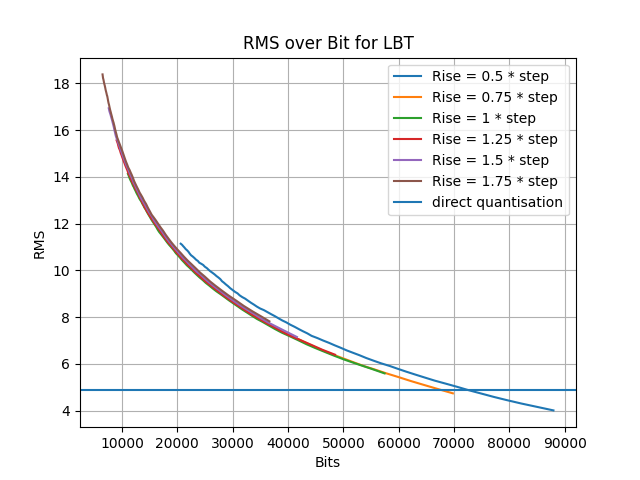

In [6]:
# LBT
from cued_sf2_lab.lbt import pot_ii
C8 = dct_ii(8)
N = 8
Pf, Pr = pot_ii(N)
t = np.s_[N//2:-N//2]
def lbt(X, s, N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    t = np.s_[N//2:-N//2]
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T
    Y = colxfm(colxfm(Xp, C).T, C).T
    return Y
def undo(Z,s,N):
    Pf, Pr = pot_ii(N, s)
    C = dct_ii(N)
    Zp = Z.copy()
    Zp[:,t] = colxfm(Zp[:,t].T,Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:],Pr.T)
    return Zp
fig, ax = plt.subplots()
ratio = [0.5,0.75,1,1.25,1.5,1.75]
for r in ratio:
    rms = []
    bit = []
    
    for step_size in np.arange(20, 100):
        N = 8
        Y = lbt(X, 1.41, N)
        # Perform quantization and other calculations
        Yq = quantise(Y, step_size, r*step_size)
        Yr = regroup(Yq, N)/N
        Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
        Zp = undo(Z,1.41,N)
        # Calculate rms_error_Z and append to rms list
        rms_error_Z = np.std(X - Zp)
        rms.append(rms_error_Z)
        
        # Calculate total_bits_bpp and append to bit list
        total_bits_bpp = dctbpp(Yr,N)
        bit.append(total_bits_bpp)

    # Plot the bit over RMS for the current ratio
    plt.plot(bit, rms, label=f"Rise = {r} * step")
rms_direct = np.std(X - quantise(X,17))
ax.axhline(y=rms_direct, label="direct quantisation")
ax.set_ylabel('RMS')
ax.set_xlabel('Bits')
ax.set_title('RMS over Bit for LBT')
ax.legend()
ax.grid(True)

In [9]:
from typing import Tuple
def quantdwt_rise(Y: np.ndarray, dwtstep: np.ndarray, n, rise) -> Tuple[np.ndarray, np.ndarray]:

    dwtent = np.zeros((3, n + 1))

    Yq = Y.copy()

    num_bits = 0


    for i in range(1, n + 1):

        m = 256 // (2 ** (i - 1))

        for k in range(3):

            if k == 0:

                row = slice(0, int(m // 2))

                col = slice(int(m // 2), int(m))

            elif k == 1:
                row = slice(int(m // 2), int(m))

                col = slice(0, int(m // 2))

            elif k == 2:

                row = slice(int(m // 2), int(m))

                col = slice(int(m // 2), int(m))

            Yq[row, col] = quantise(Yq[row, col], dwtstep[k, i], rise)

            dwtent[k, i] = bpp(Yq[row, col])

            num_bits += bpp(Yq[row, col]) * Yq[row, col].size




    # quantise final low-pass

    m = 256 // (2 ** n)

    row = slice(0, m)

    col = slice(0, m)

    Yq[row, col] = quantise(Y[row, col], dwtstep[0, n], rise)

    dwtent[0, n] = bpp(Yq[row, col])

    num_bits += bpp(Yq[row, col]) * Yq[row, col].size




    return Yq, dwtent, num_bits

<class 'numpy.ndarray'>


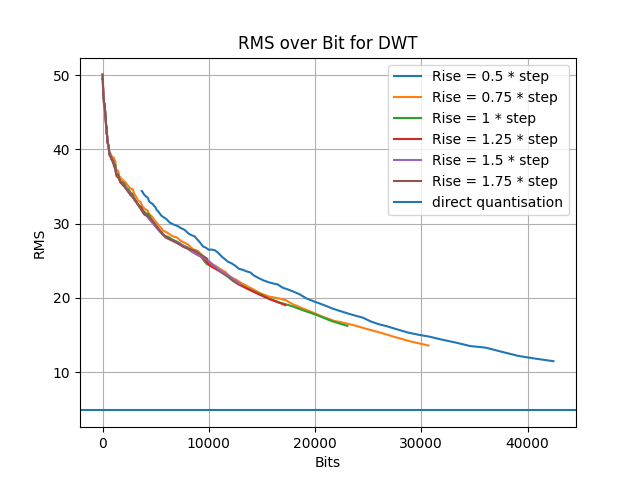

In [13]:
# from cued_sf2_lab.dwt import quantdwt
from cued_sf2_lab.dwt import dwt
from cued_sf2_lab.dwt import idwt
def nlevdwt(X, n):
    Y = X.copy()
    m = 256
    Y = dwt(X)
    for _ in range(n-1):
        m = m // 2
        Y[:m, :m] = dwt(Y[:m, :m])
 
    return Y,m


def nlevidwt(Y, n,m):
    X = Y.copy()
    # m = len(X)//(2**(n-1))
    for _ in range(n):
        X[:m, :m] = idwt(X[:m,:m])
        m = m * 2
    return X
n = 4
Y, m = nlevdwt(X, n)
print(type(Y))

fig, ax = plt.subplots()

ratio = [0.5,0.75,1,1.25,1.5,1.75]
for r in ratio:
    rms = []
    bit = []
    for dwtstep in np.arange(20,100):
        dwtstep_array = np.full((3, n+1), dwtstep)
        Yq, dwtent, num_bits = quantdwt_rise(Y, dwtstep_array,n, dwtstep*r)
        Z = nlevidwt(Yq,n, m)
        rms_error_Z = np.std(X - Z)
        rms.append(rms_error_Z)
        # Calculate total_bits_bpp and append to bit list
        Yr = regroup(Yq, N)/N
        total_bits_bpp = dctbpp(Yr,N)
        bit.append(total_bits_bpp)

        # Plot the bit over RMS for the current ratio

    
#     plt.plot(bit, rms, label=f"Rise = {r} * step")
# rms_direct = np.std(X - quantise(X,17))

# ax.axhline(y=rms_direct, label="direct quantisation")

# ax.set_ylabel('RMS')
# ax.set_xlabel('Bits')
# ax.set_title('RMS over Bit for LBT')
# ax.legend()
# ax.grid(True)
    plt.plot(bit, rms, label=f"Rise = {r} * step")
rms_direct = np.std(X - quantise(X,17))
ax.axhline(y=rms_direct, label="direct quantisation")
ax.set_ylabel('RMS')
ax.set_xlabel('Bits')
ax.set_title('RMS over Bit for DWT')
ax.legend()
ax.grid(True)


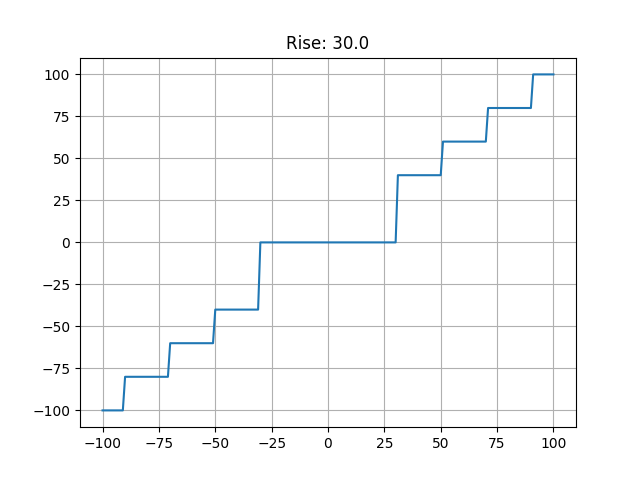

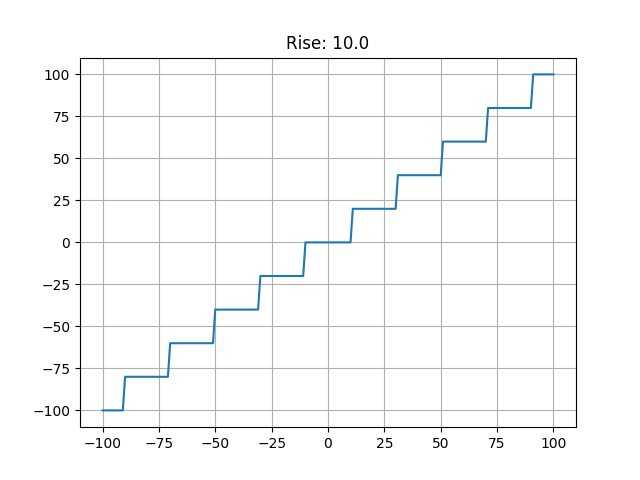

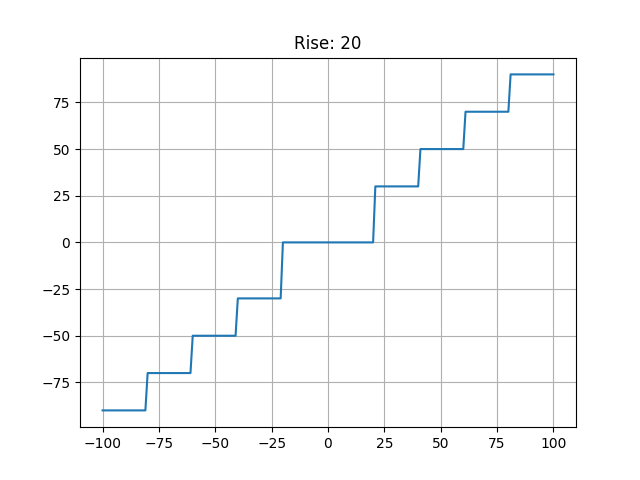

In [5]:
# your code here
x = np.arange(-100,100+1)
rise1 = [0.5*20,1*20,1.5*20]
for r in rise1:
    # rise1 = step/2
    y = quantise(x,20,r)
    fig,ax = plt.subplots()
    ax.plot(x,y)
    ax.grid()
    title = f'Rise: {r}'
    ax.set_title(title)
plt.show()

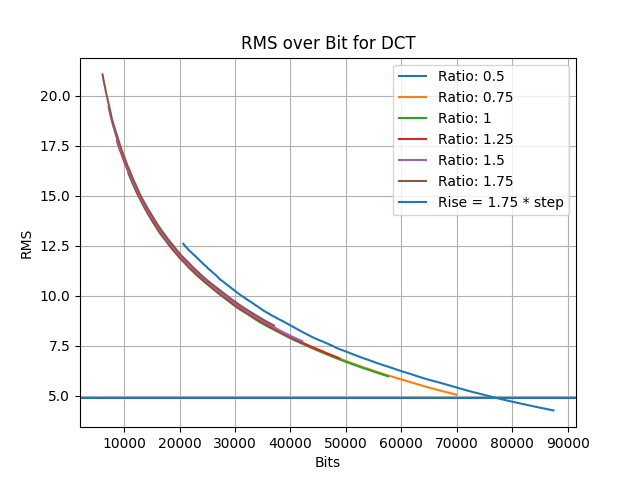

In [40]:
# You may wish to work in standalone python files (instead of notebooks) at this point!
# DCT
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
from cued_sf2_lab.dct import colxfm


fig, ax = plt.subplots()

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

X_pre_zero_mean, _ = load_mat_img(img='lighthouse.mat', img_info='X')
X = X_pre_zero_mean - 128.0
N = 8
C8 = dct_ii(8)
Y = colxfm(colxfm(X, C8).T, C8).T
def dctbpp(Yr,N):
    sub_images = Yr.reshape(N,256//N,N,256//N).swapaxes(1,2)
    total_bits = 0
    for i in range(sub_images.shape[0]):
        for j in range(sub_images.shape[1]):
            Ys = sub_images[i][j]
            total_bits += bpp(Ys)*Ys.size
    return total_bits

ratio = [0.5,0.75,1,1.25,1.5,1.75]
for r in ratio:
    rms = []
    bit = []
    
    for step_size in np.arange(20, 100):
        N = 8
        # Perform quantization and other calculations
        Yq = quantise(Y, step_size, r*step_size)
        Yr = regroup(Yq, N)/N
        Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
        # Calculate rms_error_Z and append to rms list
        rms_error_Z = np.std(X - Z)
        rms.append(rms_error_Z)
        
        # Calculate total_bits_bpp and append to bit list
        total_bits_bpp = dctbpp(Yr,N)
        bit.append(total_bits_bpp)

    # Plot the bit over RMS for the current ratio
    plt.plot(bit, rms, label=f"Ratio: {r}")
rms_direct = np.std(X - quantise(X,17))
ax.axhline(y=rms_direct, label=f"Rise = {r} * step")
ax.set_ylabel('RMS')
ax.set_xlabel('Bits')
ax.set_title('RMS over Bit for DCT')
ax.legend()
ax.grid(True)

In [44]:
#DCT
def conditions(num, r, c):
    conditions_list = [None, r == 224 and c == 224, (r == 224 and c == 224) or (r == 192 and c == 224), (r == 224 and c == 224) or (r == 192 and c == 224) or (r == 224 and c == 192), (r == 224 and c == 224) or (r == 192 and c == 192) or (r == 192 and c == 224) or (r == 224 and c == 192)]
    return(conditions_list[num])

step_sizes = np.linspace(1, 30, 300)
num_of_supress_images = [0, 1, 2, 3, 4]
number_of_bits_DCT_suppressed = []
rms_error_DCT_suppressed = []
for num in num_of_supress_images:
    temp_number_of_bits = []
    temp_rms_error = []
    for step in step_sizes:
        DCT_N = 8
        C8 = dct_ii(DCT_N)
        Y8 = colxfm(colxfm(X, C8).T, C8).T
        Y8r = regroup(Y8, DCT_N)
        Y8c = Y8r.copy()
        it =  Y8r.shape[0]//DCT_N
        for r in range(0, Y8.shape[0], it):
            for c in range(0, Y8.shape[1], it):
                if conditions(num, r, c):
                    Y8c[r: r + it, c: c + it] = quantise(Y8c[r: r + it, c: c + it], step, 100)
                else:
                    Y8c[r: r + it, c: c + it] = quantise(Y8c[r: r + it, c: c + it], step, step)

        Y8q = regroup(Y8c, 32)
        temp_number_of_bits.append(dctbpp(Y8c, DCT_N))
        Zq = colxfm(colxfm(Y8q.T, C8.T).T, C8.T)
        temp_rms_error.append(np.std(X - Zq))
        
    number_of_bits_DCT_suppressed.append(temp_number_of_bits)
    rms_error_DCT_suppressed.append(temp_rms_error)

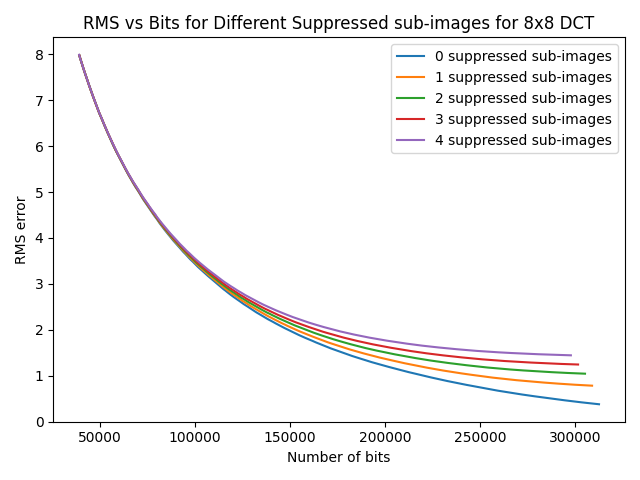

In [53]:
fig, ax = plt.subplots()
ax.plot(number_of_bits_DCT_suppressed[0], rms_error_DCT_suppressed[0], label = '0 suppressed sub-images')
ax.plot(number_of_bits_DCT_suppressed[1], rms_error_DCT_suppressed[1], label = '1 suppressed sub-images')
ax.plot(number_of_bits_DCT_suppressed[2], rms_error_DCT_suppressed[2], label = '2 suppressed sub-images')
ax.plot(number_of_bits_DCT_suppressed[3], rms_error_DCT_suppressed[3], label = '3 suppressed sub-images')
ax.plot(number_of_bits_DCT_suppressed[4], rms_error_DCT_suppressed[4], label = '4 suppressed sub-images')

ax.set(title  = "RMS vs Bits for Different Suppressed sub-images for 8x8 DCT")
ax.set_xlabel("Number of bits")
ax.set_ylabel("RMS error")
fig.tight_layout()
plt.legend()

In [54]:
#LBT
import numpy as np
def conditions(num, r, c):
    conditions_list = [None, r == 224 and c == 224, (r == 224 and c == 224) or (r == 192 and c == 224), (r == 224 and c == 224) or (r == 192 and c == 224) or (r == 224 and c == 192), (r == 224 and c == 224) or (r == 192 and c == 192) or (r == 192 and c == 224) or (r == 224 and c == 192)]
    return(conditions_list[num])
# optimal_scale = 1.489795918367347
step_sizes = np.linspace(1, 30, 300)
num_of_supress_images = [0, 1, 2, 3, 4]
number_of_bits_LBT_suppressed = []
rms_error_LBT_suppressed = []
for num in num_of_supress_images:
    temp_number_of_bits = []
    temp_rms_error = []
    for step in step_sizes:
        LBT_N = 8
        C8 = dct_ii(LBT_N)
        Pf, Pr = pot_ii(LBT_N, np.sqrt(2))
        t = np.s_[LBT_N//2:-LBT_N//2] 
        Xp = X.copy()  
        Xp[t,:] = colxfm(Xp[t,:], Pf)
        Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
        
        Y8 = colxfm(colxfm(Xp, C8).T, C8).T
        Y8r = regroup(Y8, LBT_N)
        Y8c = Y8r.copy()
        it =  Y8r.shape[0]//LBT_N
        for r in range(0, Y8.shape[0], it):
            for c in range(0, Y8.shape[1], it):
                if conditions(num, r, c):
                    Y8c[r: r + it, c: c + it] = quantise(Y8c[r: r + it, c: c + it], step, 100)
                else:
                    Y8c[r: r + it, c: c + it] = quantise(Y8c[r: r + it, c: c + it], step, step)

        Y8q = regroup(Y8c, 32)
        temp_number_of_bits.append(dctbpp(Y8c, LBT_N))
        
        
        Zq = colxfm(colxfm(Y8q.T, C8.T).T, C8.T)
        Zp = Zq.copy()
        Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
        Zp[t,:] = colxfm(Zp[t,:], Pr.T)
        
        temp_rms_error.append(np.std(X - Zp))
        
    number_of_bits_LBT_suppressed.append(temp_number_of_bits)
    rms_error_LBT_suppressed.append(temp_rms_error)

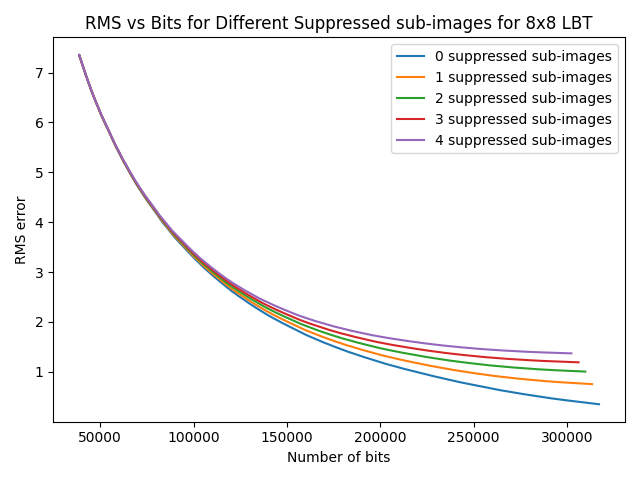

In [55]:
fig, ax = plt.subplots()
ax.plot(number_of_bits_LBT_suppressed[0], rms_error_LBT_suppressed[0], label = '0 suppressed sub-images')
ax.plot(number_of_bits_LBT_suppressed[1], rms_error_LBT_suppressed[1], label = '1 suppressed sub-images')
ax.plot(number_of_bits_LBT_suppressed[2], rms_error_LBT_suppressed[2], label = '2 suppressed sub-images')
ax.plot(number_of_bits_LBT_suppressed[3], rms_error_LBT_suppressed[3], label = '3 suppressed sub-images')
ax.plot(number_of_bits_LBT_suppressed[4], rms_error_LBT_suppressed[4], label = '4 suppressed sub-images')
ax.set(title  = "RMS vs Bits for Different Suppressed sub-images for 8x8 LBT")
ax.set_xlabel("Number of bits")
ax.set_ylabel("RMS error")
fig.tight_layout()
plt.legend()

Most current image compression standards use quantisers with a
double-width centre step (`rise1 = step`). Do not spend too much time
on this as the compression gains are likely to be quite small.

<div class="alert alert-block alert-danger">


Discuss whether your results indicate that `rise1 = step`
is a reasonable compromise if all quantisers are to be similar.
</div>

A final strategy which you can consider is to completely suppress some
sub-images or DCT coefficients.  This is equivalent to increasing `rise1`
to a very large value for these components.  In the sub-images / coefficients
which represent only the highest horizontal and vertical frequency components
combined, the effects of suppression can be almost unnoticable and yet
a useful saving in number of bits can be achieved.

<div class="alert alert-block alert-danger">

Investigate any additional gains which can be achieved with suppression
of some sub-images / coefficients.
</div>